### Initial run

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/gpu_logging_test")

In [3]:
# s3_folder_filter="1011_4/*benchmark_e2e*"
scratch_folder_filter="*benchmark_e2e*"

Load the data

In [4]:
# df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 242.54it/s]


Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

In [5]:
unique_functions_scratch = np.unique(df_dataloader_scratch["item_x"])
print(f"Unique functions: {unique_functions_scratch}")

colors = {}
for i, color in zip(unique_functions_scratch, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
lanes={}
for i, lane in zip(unique_functions_scratch, range(len(unique_functions_scratch))):
    lanes[str(i)] = lane
    
print(f"Lanes: {lanes}")

# unique_runs_s3 = np.unique(df_dataloader_s3["run"])
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']
Lanes: {'batch': 0, 'next_data': 1, 'run_training_batch': 2, 'training_batch_to_device': 3}


Extract the GPU Utilization data

In [6]:
num_gpus = 8

In [7]:
import datetime
import time 
def extract_gpuutil2(
    output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
num_gpus: int = None):
    files = list(output_base_folder.rglob(f"{folder_filter}/gpuutil-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0: continue
        header = []
        for i in range(num_gpus):
            header.append(f"gpu_util_{i}")
            header.append(f"mem_util_{i}")
            header.append(f"timestamp_{i}")
        header.append("run")
        lines = []
        for result in results:
            line = []
            for item in result["gpu_data"]:
                line.append(result["gpu_data"][item]["gpu_util"])
                line.append(result["gpu_data"][item]["mem_util"])
                date_time = datetime.datetime.strptime(result["gpu_data"][item]["timestamp"].strip(), 
                                                       "%Y/%m/%d %H:%M:%S.%f")
                line.append(time.mktime(date_time.timetuple()))
            line.append(working_file_path.parent.name)
            lines.append(line)
        results = pd.DataFrame.from_records(lines)
        data.append(results)
    df = pd.concat(data)
    print(f"Header: {header}")
    df.columns = header
    df.groupby
    return df

In [8]:
df_gpuutil_scratch = extract_gpuutil2(output_base_folder, folder_filter=scratch_folder_filter, num_gpus=num_gpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:01<00:00, 92.49it/s]

Header: ['gpu_util_0', 'mem_util_0', 'timestamp_0', 'gpu_util_1', 'mem_util_1', 'timestamp_1', 'gpu_util_2', 'mem_util_2', 'timestamp_2', 'gpu_util_3', 'mem_util_3', 'timestamp_3', 'gpu_util_4', 'mem_util_4', 'timestamp_4', 'gpu_util_5', 'mem_util_5', 'timestamp_5', 'gpu_util_6', 'mem_util_6', 'timestamp_6', 'gpu_util_7', 'mem_util_7', 'timestamp_7', 'run']


In [10]:
df_gpuutil_scratch

,gpu_util_0,mem_util_0,timestamp_0,gpu_util_1,mem_util_1,timestamp_1,gpu_util_2,mem_util_2,timestamp_2,gpu_util_3,...,gpu_util_5,mem_util_5,timestamp_5,gpu_util_6,mem_util_6,timestamp_6,gpu_util_7,mem_util_7,timestamp_7,run
0,0.0,0.0,1.643929e+09,20220204f000052_benchmark_e2e_torch_scratch_25...,NaN,NaN,None,NaN,NaN,None,...,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None
1,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,20220204f000052_benchmark_e2e_torch_scratch_25...,NaN,NaN,None,...,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None
2,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,20220204f000052_benchmark_e2e_torch_scratch_25...,...,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None
3,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,0.0,...,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None
4,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,0.0,0.0,1.643929e+09,0.0,...,20220204f000052_benchmark_e2e_torch_scratch_25...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,88.0,54.0,1.643926e+09,0.0,...,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,20220203f230308_benchmark_e2e_torch_scratch_64...
924,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,88.0,54.0,1.643926e+09,0.0,...,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,20220203f230308_benchmark_e2e_torch_scratch_64...
925,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,88.0,54.0,1.643926e+09,0.0,...,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,20220203f230308_benchmark_e2e_torch_scratch_64...
926,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,88.0,54.0,1.643926e+09,0.0,...,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,0.0,0.0,1.643926e+09,20220203f230308_benchmark_e2e_torch_scratch_64...


In [11]:
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

In [12]:
print(unique_runs_scratch)

['20220203f230308_benchmark_e2e_torch_scratch_64_4_16_1_asyncio_sync'
 '20220203f230338_benchmark_e2e_lightning_scratch_64_4_16_1_asyncio_sync'
 '20220204f000052_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync'
 '20220204f000247_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync']


In [14]:
df_gpuutil_scratch_corr = df_gpuutil_scratch[num_gpus:]
df_gpuutil_scratch_corr.dropna(subset = ["run"], inplace=True)
unique_runs_scratch_2 = np.unique(df_gpuutil_scratch_corr["run"].to_list())
print(unique_runs_scratch_2)

['20220203f230308_benchmark_e2e_torch_scratch_64_4_16_1_asyncio_sync'
 '20220203f230338_benchmark_e2e_lightning_scratch_64_4_16_1_asyncio_sync'
 '20220204f000052_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync'
 '20220204f000247_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync']


### Plot function timelines for remote storage (AWS S3)

### Plot function timelines for local storage

In [15]:
def show_timelines_with_gpu2(df, gpu_util, lanes, colors, run, flat=False, show_gpu=False, zoom=False, zoom_epochs=1, gpu_index="2"):
    fig, ax = plt.subplots(figsize=(30, 25))
    plt.rcParams.update({"font.size": 18})
    start = min(df["start_time_x"])
    end = max(df["end_time_y"])
    gpu_start = min(gpu_util[f"timestamp_{gpu_index}"])

    total_runtime = end - start
    number_of_epochs = 20

    if zoom:
        df = df[df["start_time_x"] < start + ((total_runtime / number_of_epochs) * zoom_epochs)]
        gpu_util = gpu_util[gpu_util[f"timestamp_{gpu_index}"] < gpu_start + ((total_runtime / number_of_epochs) * zoom_epochs)]

    lane = 0
    for _, row in df.sort_values(["start_time_x"], ascending=True).iterrows():
        duration = row["end_time_y"] - row["start_time_x"]
        x1 = row["start_time_x"] - start
        if duration < 0.15:
            duration = 0.2
        x2 = x1 + duration
        if not flat:
            lane += 10
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=3)

    ax.set_xlabel("Experiment duration (S)", loc="right")
    ax.set_ylabel("Operation activity lane", loc="center")
    filename = run.split("_")

    ax.legend()
    ax.grid(linestyle="--", which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=5,
    )

    gpu_util_mean_no_zeros = 0

    if show_gpu:
        ax2 = ax.twinx()
        ax2.set_ylabel("GPU/Memory utilization (green, maroon) [%]")

        r"{\fontsize{50pt}{3em}\selectfont{}a}{\fontsize{20pt}{3em}\selectfont{}N"
        ax2.set_ylim([-3, 103])
        gpu_events = []
        for i in gpu_util[f"timestamp_{gpu_index}"]:
            gpu_events.append(i - start)
        ax2.plot(gpu_events, gpu_util[f"gpu_util_{gpu_index}"], color="cyan", linestyle="--", linewidth=2)
        ax2.plot(gpu_events, gpu_util[f"mem_util_{gpu_index}"], color="maroon", linestyle="--", linewidth=2)
        gpu_util_zeros = (len(gpu_util[gpu_util[f"gpu_util_{gpu_index}"] == 0][f"gpu_util_{gpu_index}"]) / len(gpu_util[f"gpu_util_{gpu_index}"])) * 100
        gpu_util_mean_no_zeros = np.mean(gpu_util[gpu_util[f"gpu_util_{gpu_index}"] > 0][f"gpu_util_{gpu_index}"])
        mem_util_mean = np.mean(gpu_util[f"mem_util_{gpu_index}"])
        mem_util_mean_no_zeros = np.mean(gpu_util[gpu_util[f"mem_util_{gpu_index}"] > 0][f"mem_util_{gpu_index}"])
        ax2.plot(
            gpu_events, [gpu_util_mean_no_zeros] * len(gpu_events), label="GPU Util Mean", linewidth=2, color="cyan"
        )
        ax2.plot(
            gpu_events, [mem_util_mean_no_zeros] * len(gpu_events), label="Mem Util Mean", linewidth=2, color="maroon"
        )
        print(gpu_util_mean_no_zeros, mem_util_mean_no_zeros)
        ax2.legend()

    ax.set_title(
        f"Total runtime per operation \n Implementation: {filename[9]},"
        # f" use cache: {filename[8]}, "
        f" batch size: {filename[5]}, "
        f" library: {filename[3]}, "
        f"\n GPU unused: {round(gpu_util_zeros, 2)} %, "
        f" mean GPU usage: {round(gpu_util_mean_no_zeros, 2)} %",
        loc="center",
    )

    plt.show()
    return {
        "runtime": end - start,
        "gpu_util_zero": gpu_util_zeros,
        "gpu_util_mean_no_zeros": gpu_util_mean_no_zeros,
        "mem_util_mean": mem_util_mean,
        "mem_util_mean_no_zeros": mem_util_mean_no_zeros,
        "implementation": filename[9],
        "cache": filename[8],
        "library": filename[3],
    }

20220203f230308_benchmark_e2e_torch_scratch_64_4_16_1_asyncio_sync
72.4215456674473 46.972151898734175


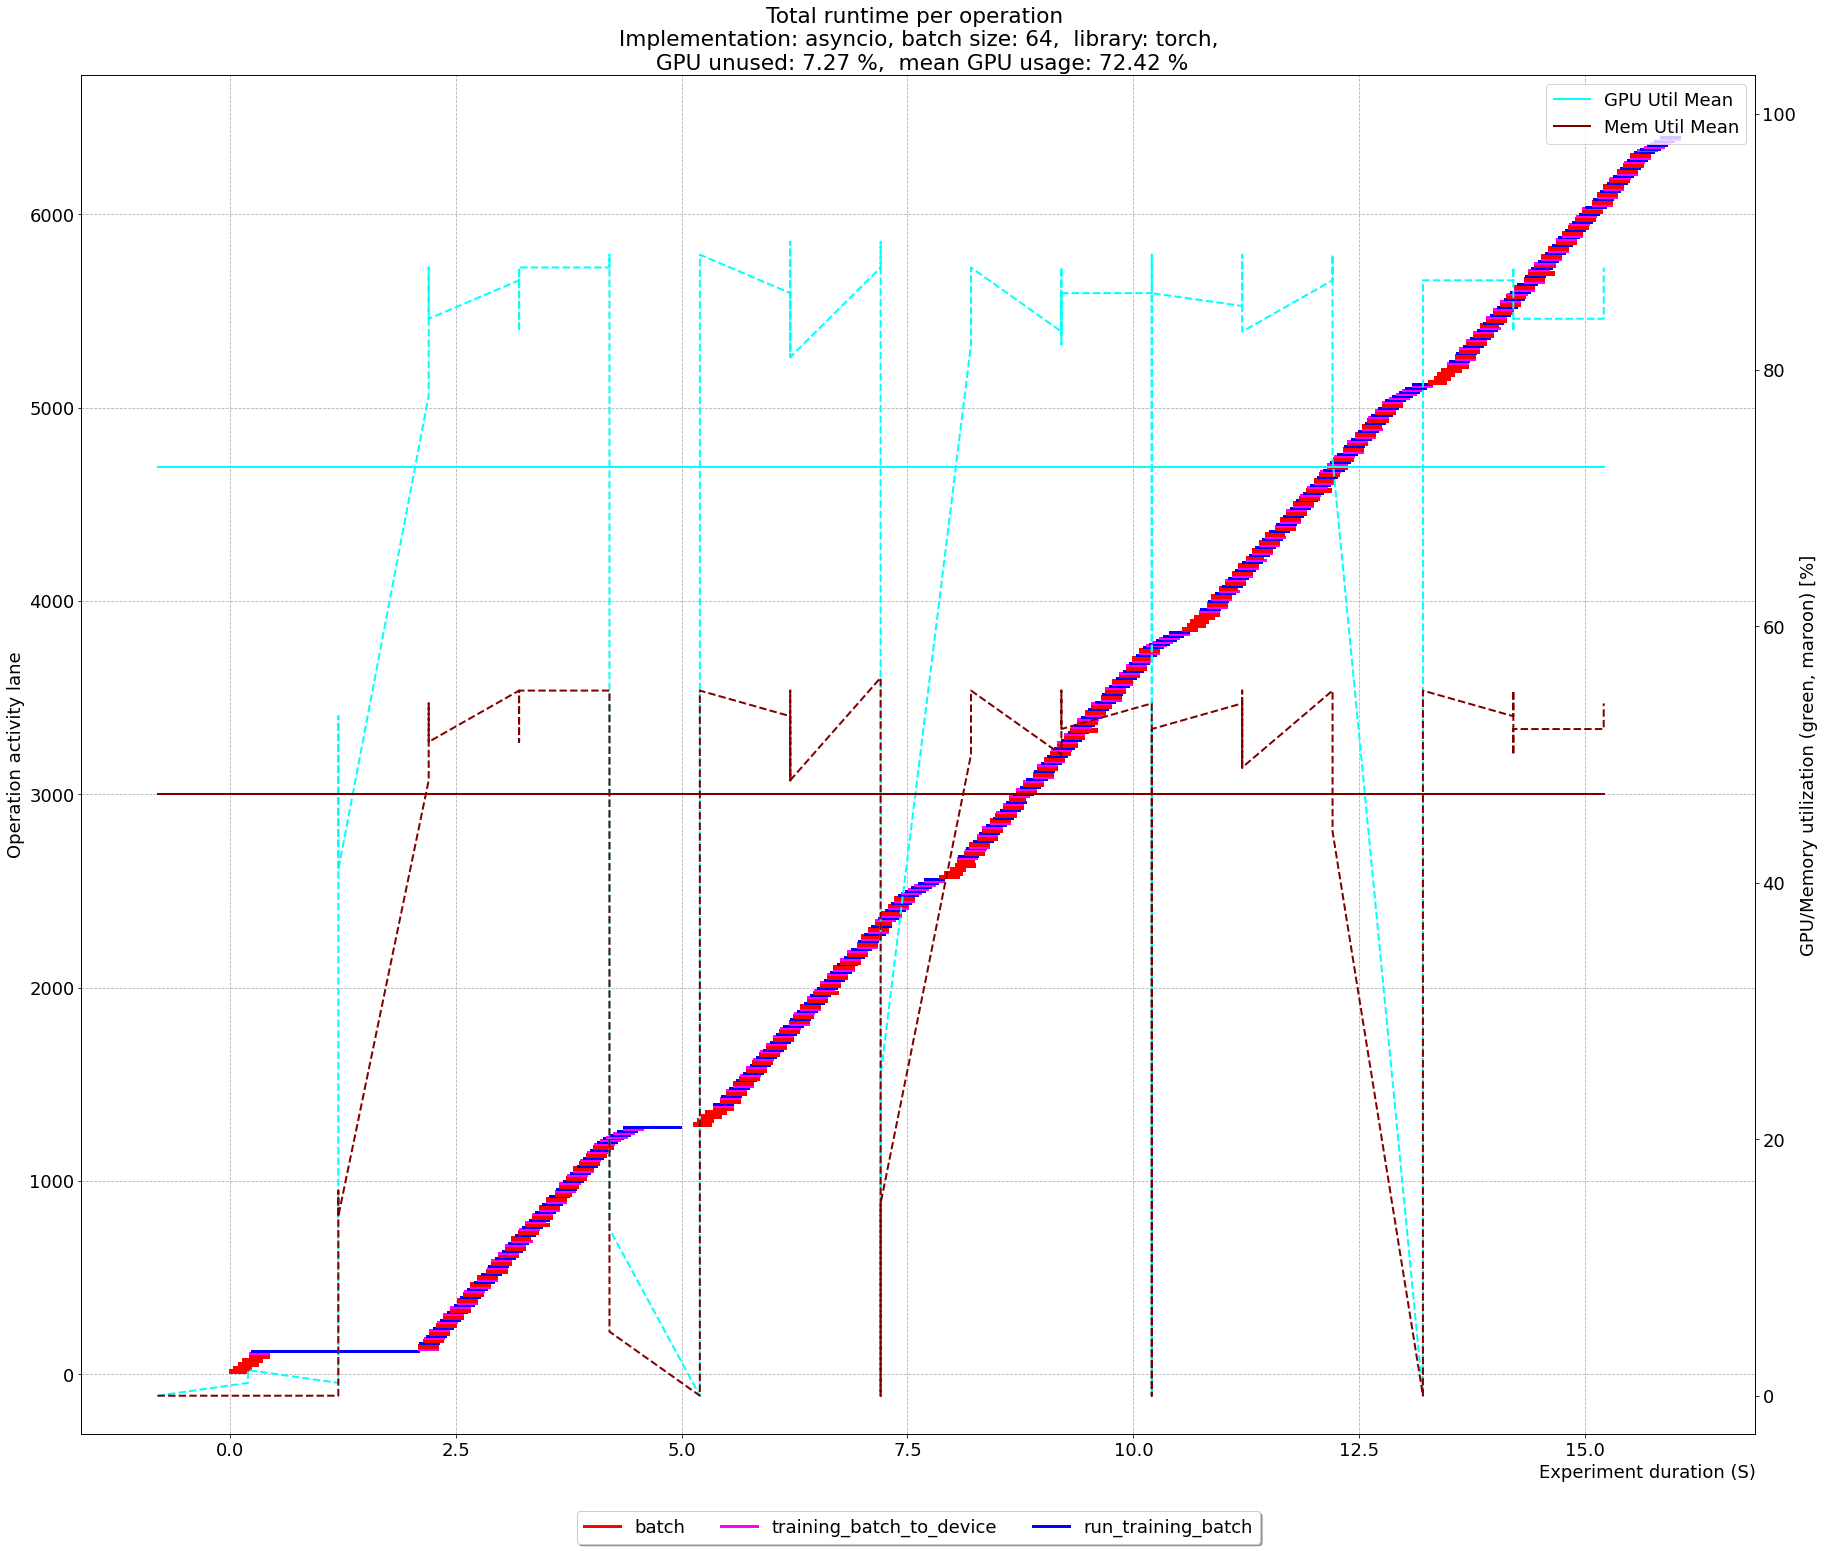

20220203f230338_benchmark_e2e_lightning_scratch_64_4_16_1_asyncio_sync
39.319309600863 14.781065088757396


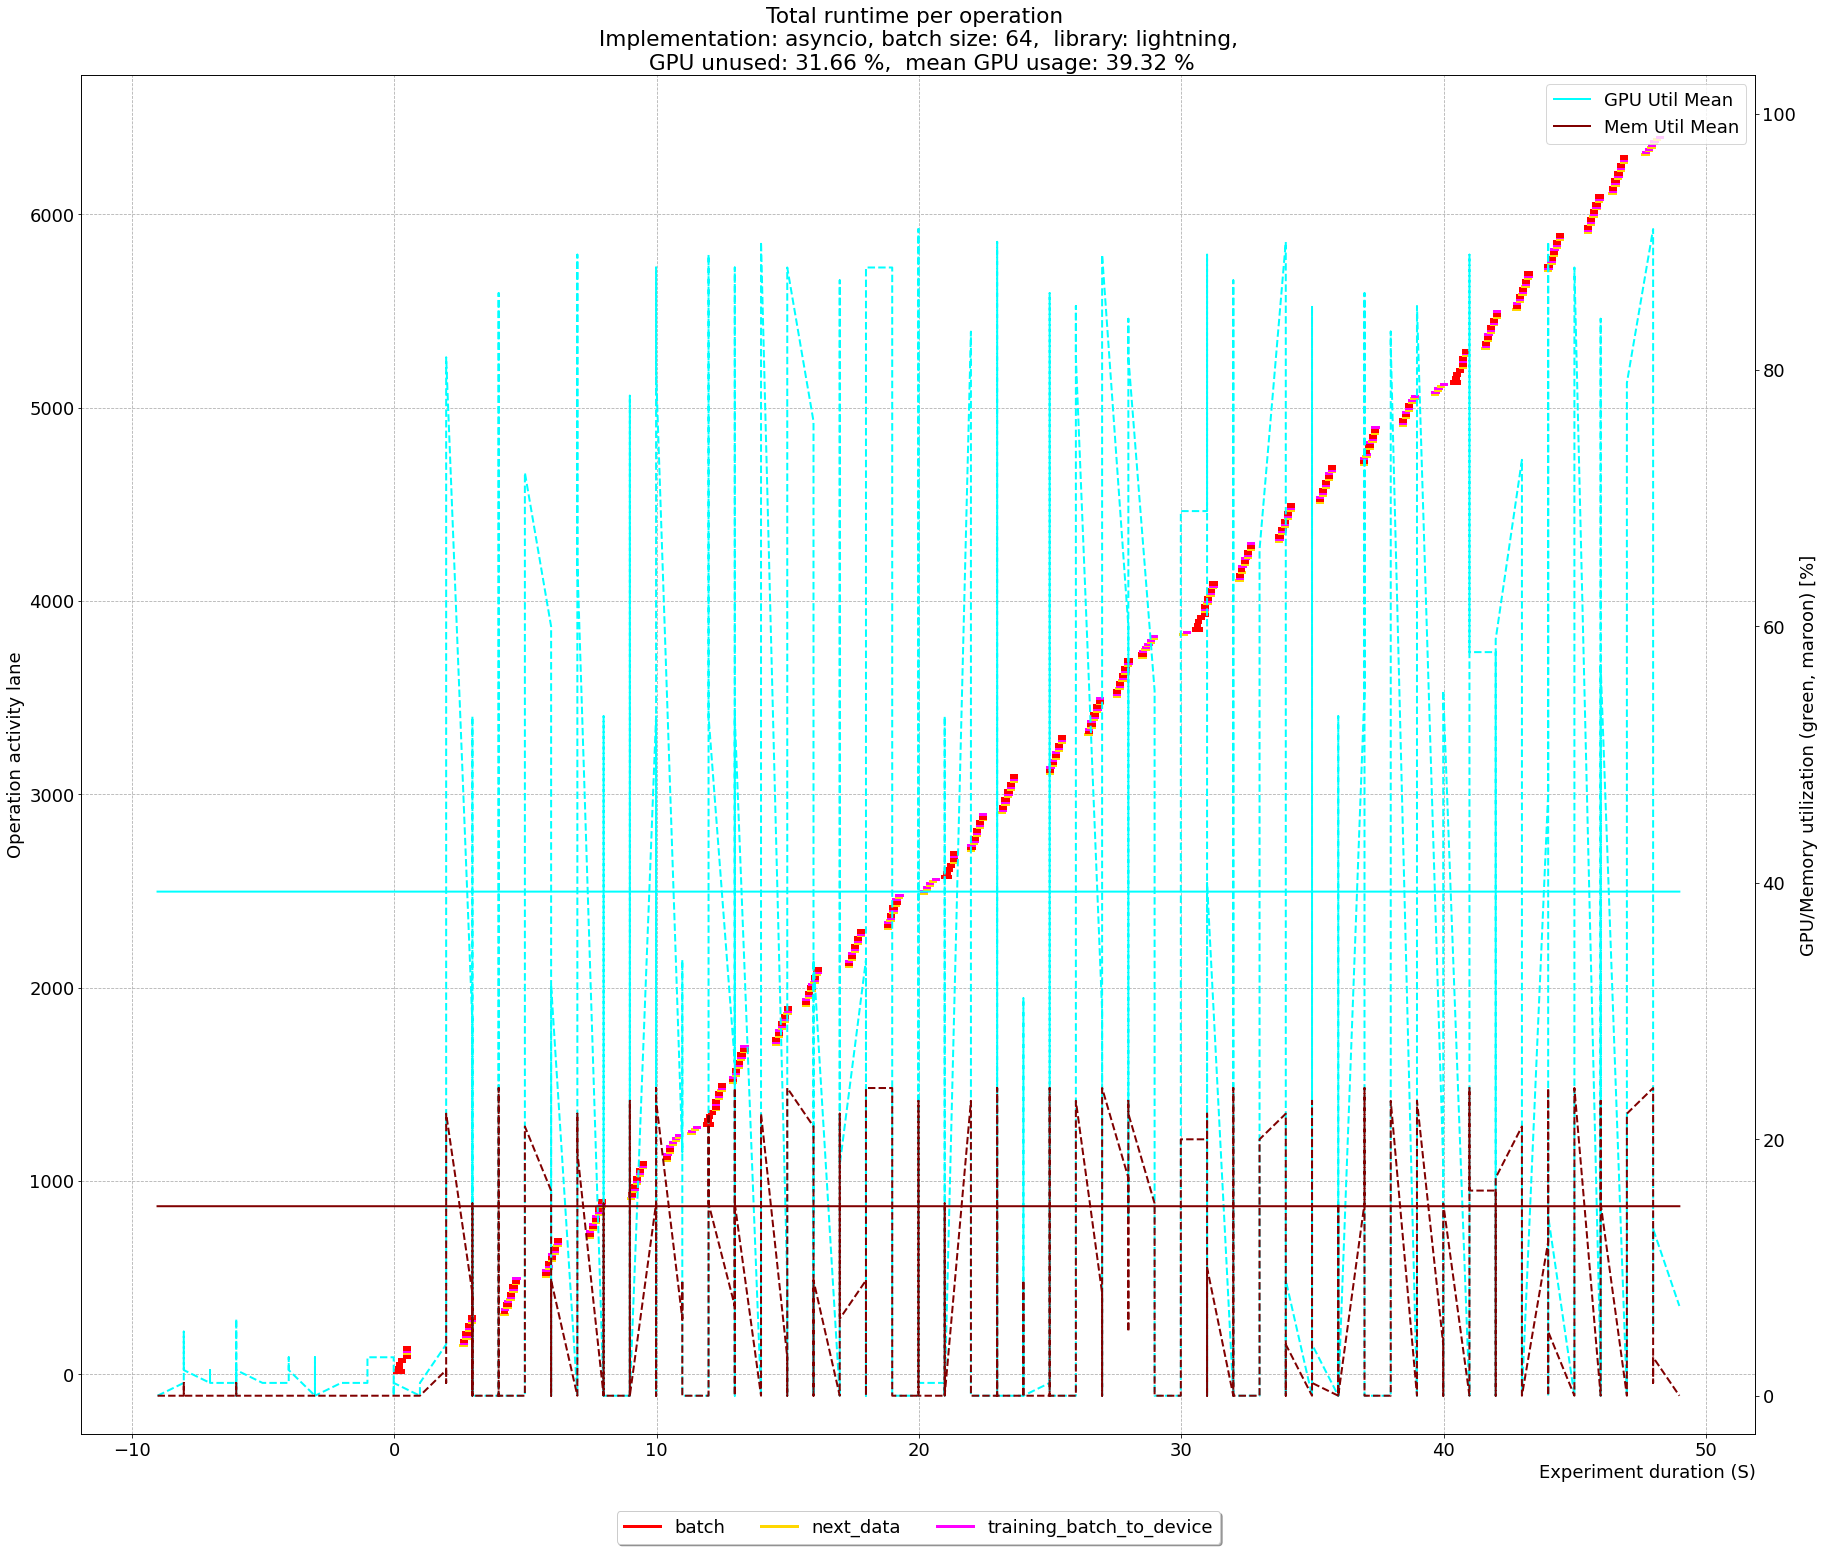

20220204f000052_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync
83.15898843364046 46.36783216783217


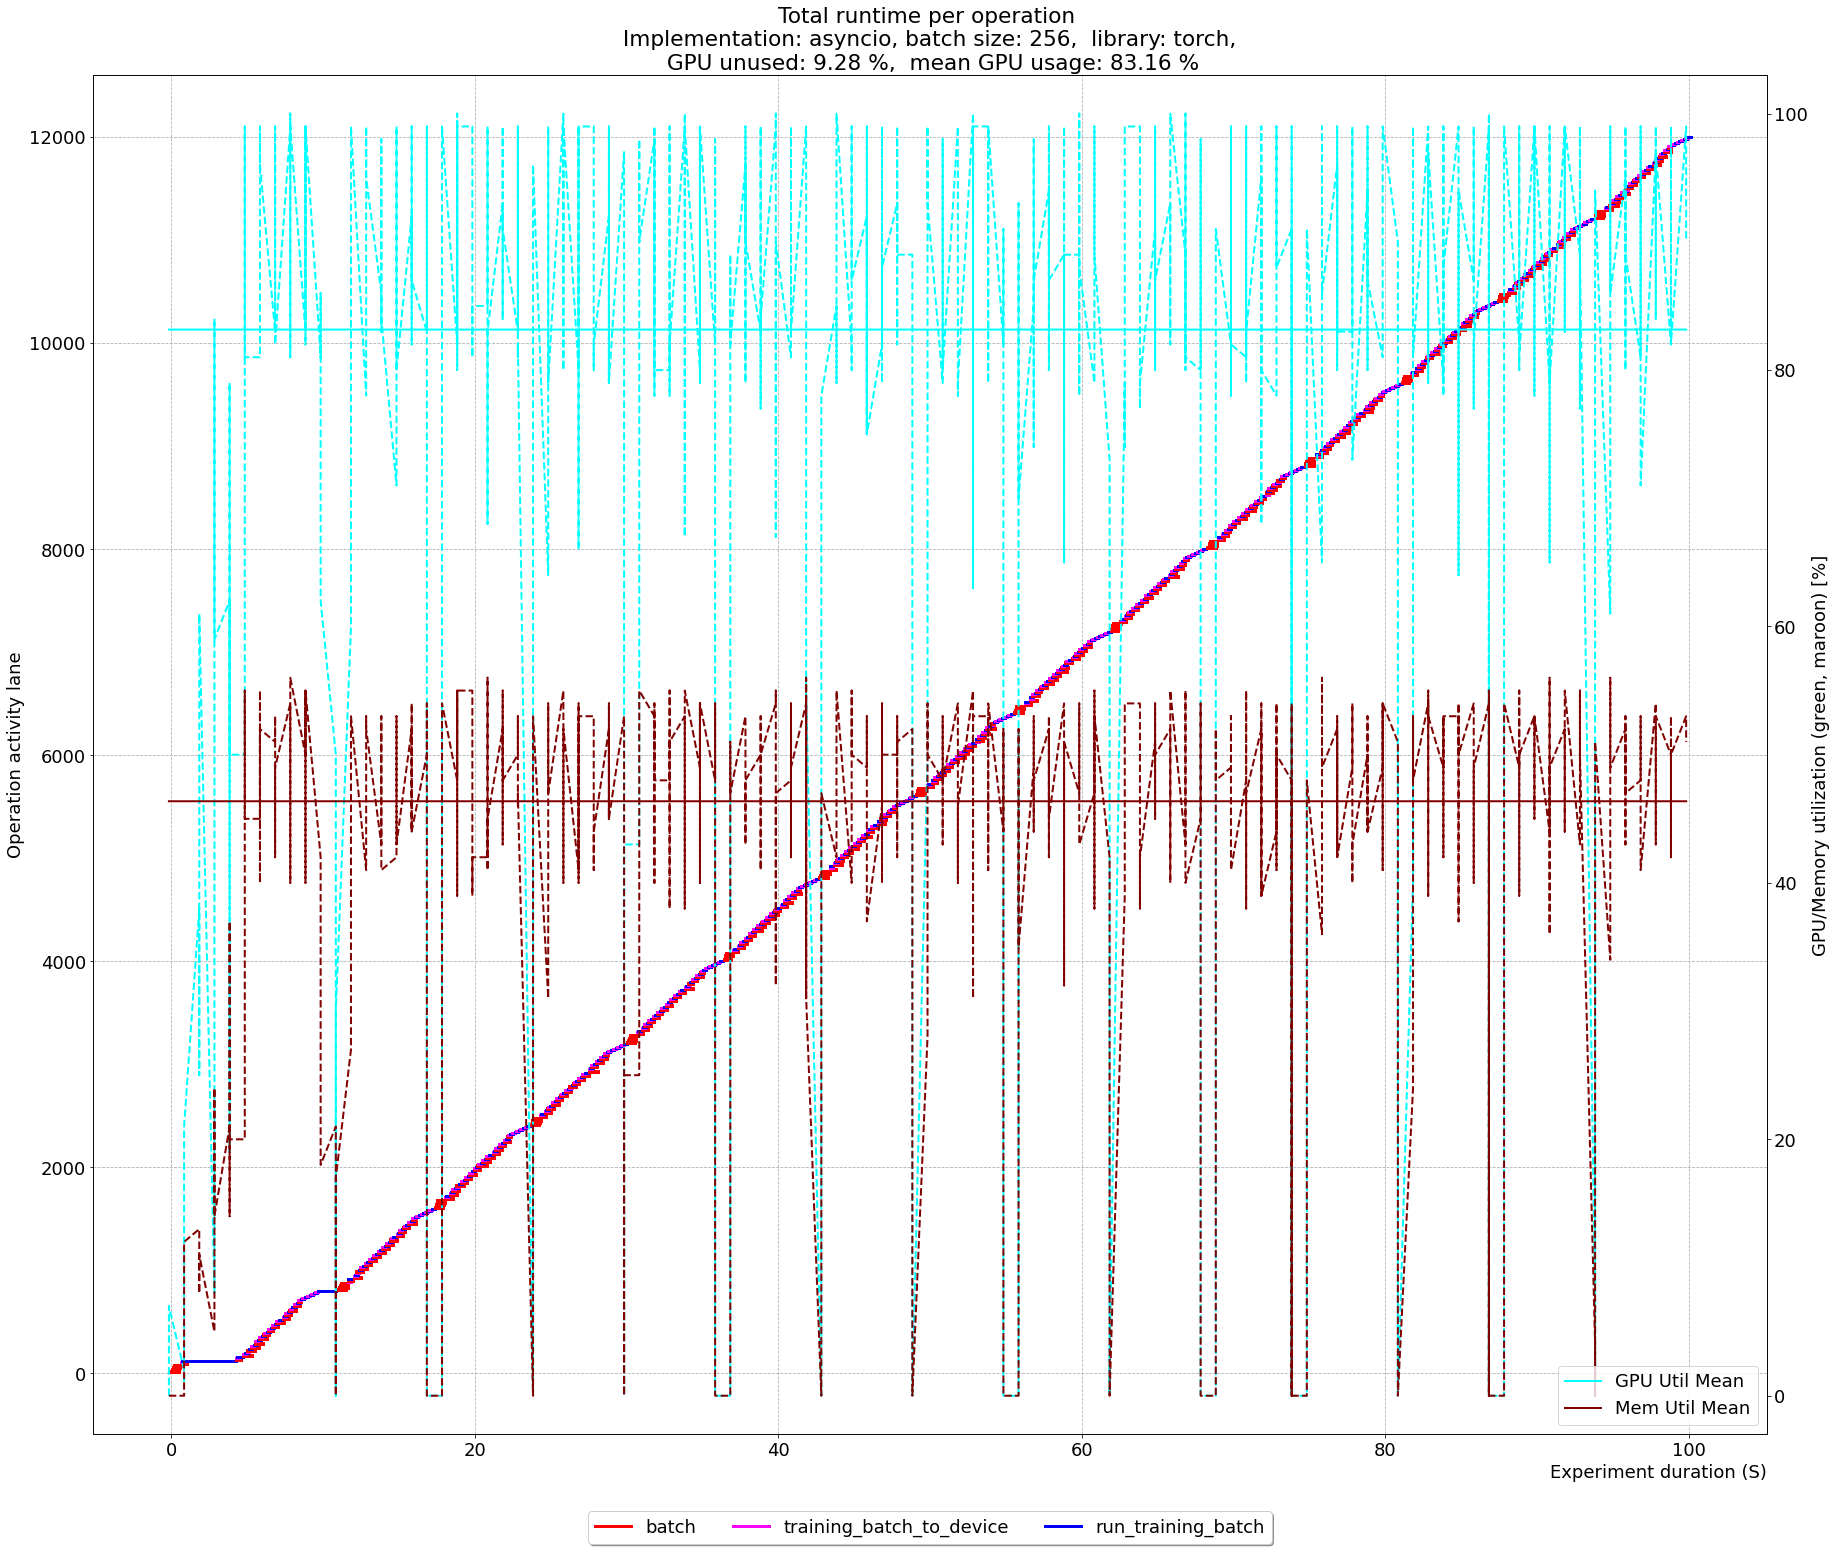

20220204f000247_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync
68.88160390138174 21.44945567651633


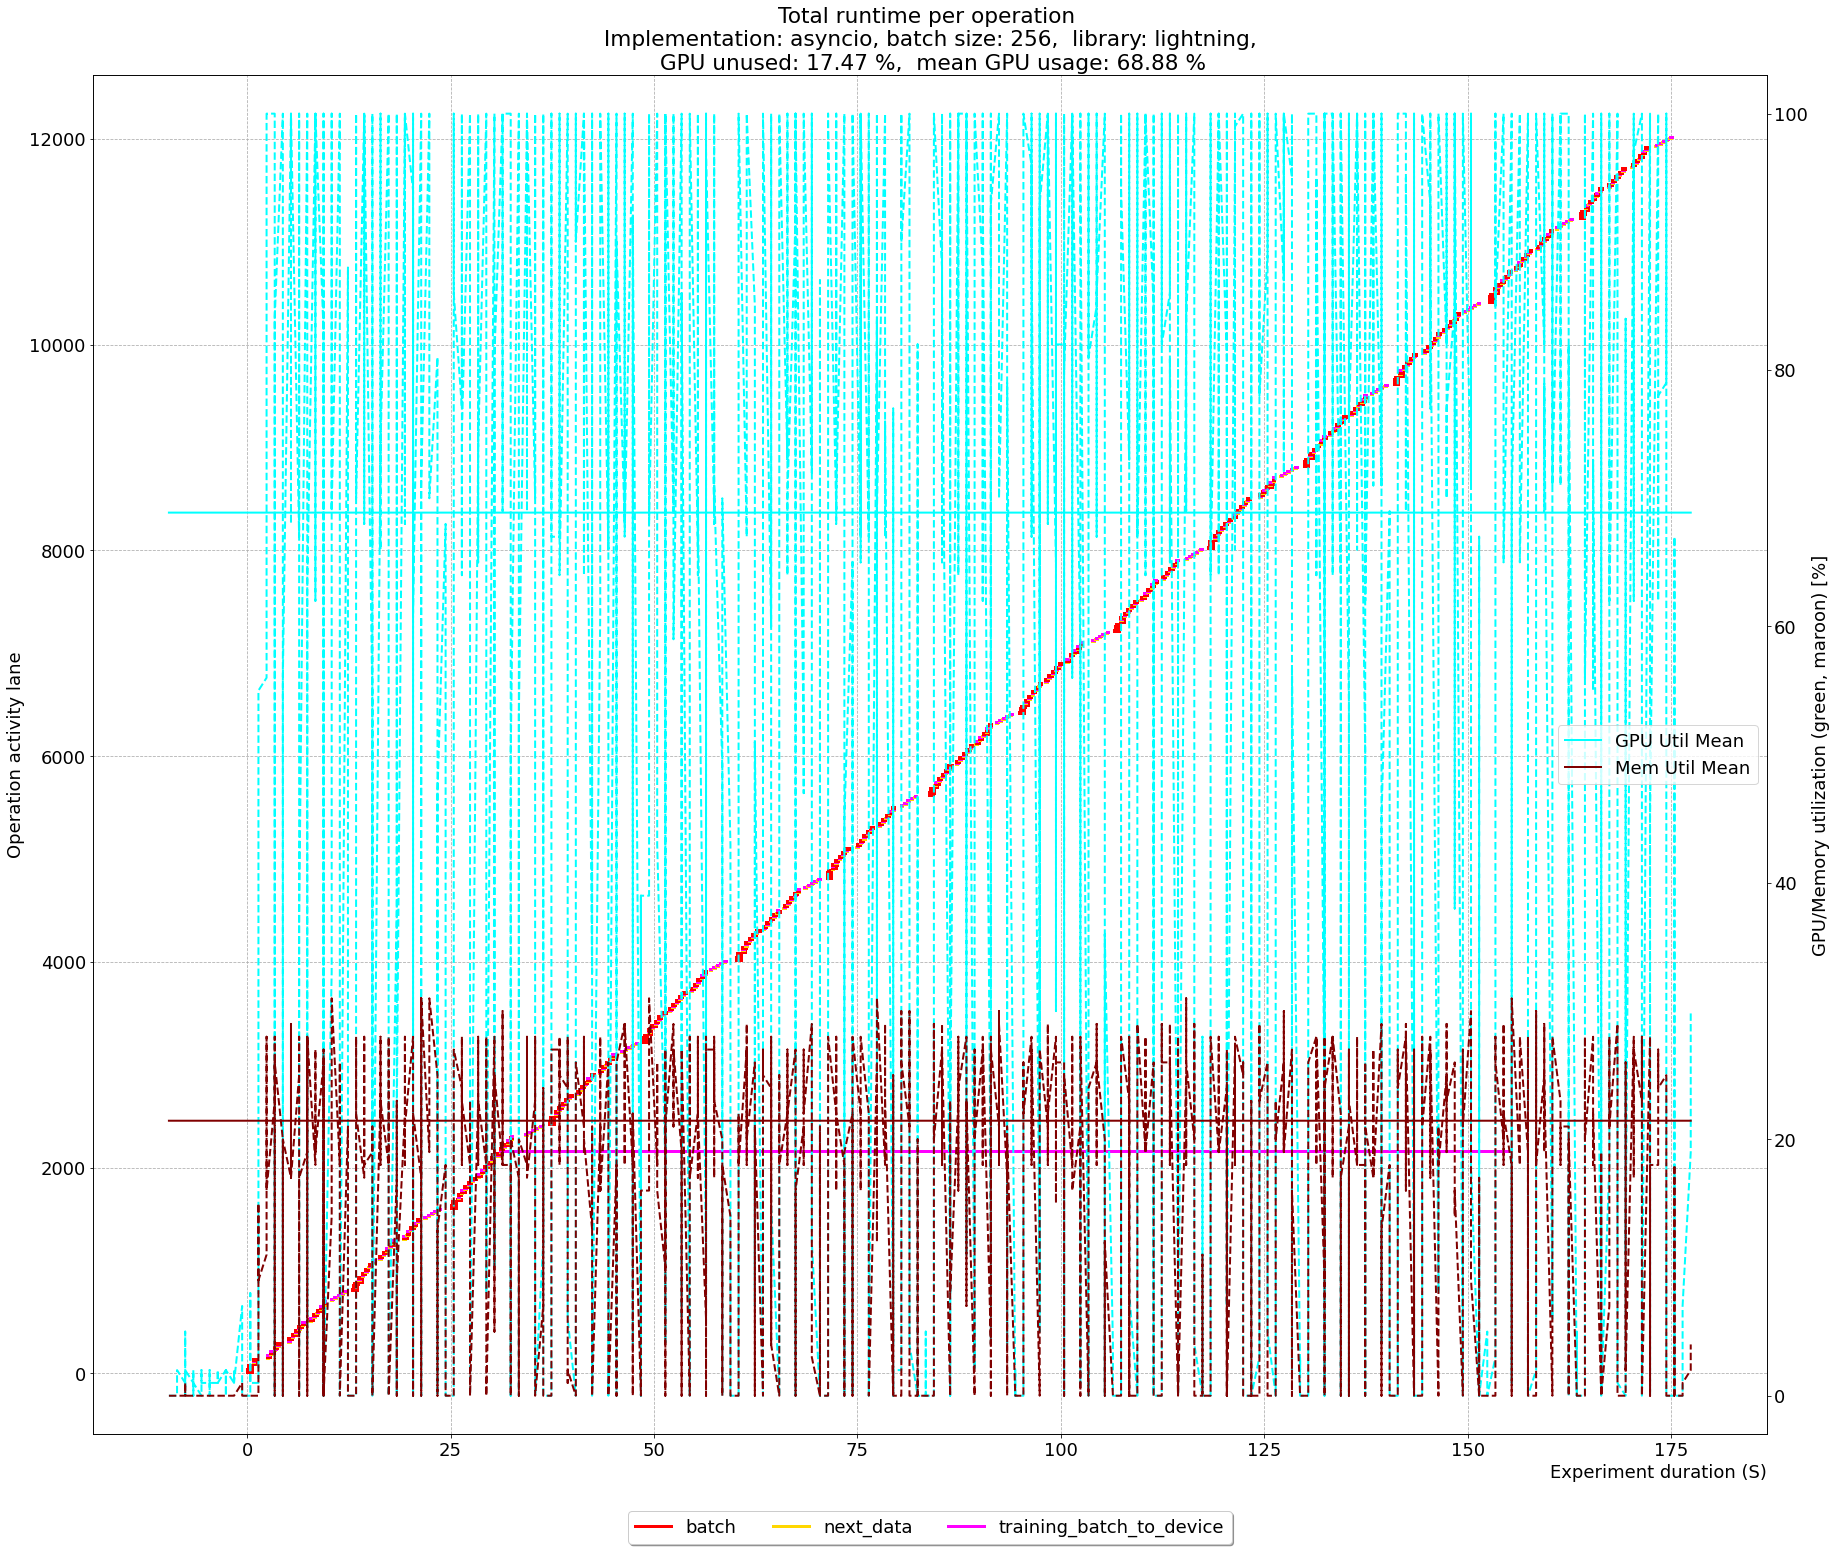

In [17]:
returns_scratch = []
function = ""

for run in sorted(unique_runs_scratch):
    print(run)
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch_corr[df_gpuutil_scratch_corr["run"]==run]
    returns_scratch.append(show_timelines_with_gpu2(df, dfgpu, lanes, colors, run, False, True, False, 2))

### Result tables
Print throughput in loaded images per second, and function duration in seconds, for S3 and Scratch

In [18]:
results = pd.DataFrame.from_records(data=returns_scratch)
results["throughput"] = 15000 / results["runtime"]
results.sort_values(["runtime", "library"], ascending=True)

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput
0,15.858247,7.274701,72.421546,40.290988,46.972152,asyncio,1,torch,945.880067
1,48.137000,31.662366,39.319310,7.366015,14.781065,asyncio,1,lightning,311.610611
2,99.985622,9.283301,83.158988,41.271741,46.367832,asyncio,1,torch,150.021570
3,174.918581,17.473449,68.881604,15.418670,21.449456,asyncio,1,lightning,85.754183


Batch extraction

In [19]:
unique_functions_scratch = np.unique(df_dataloader_scratch["item_x"])
print(f"Unique functions: {unique_functions_scratch}")

colors = {}
for i, color in zip(unique_functions_scratch, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
lanes={}
for i, lane in zip(unique_functions_scratch, range(len(unique_functions_scratch))):
    lanes[str(i)] = lane
    
print(f"Lanes: {lanes}")

unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']
Lanes: {'batch': 0, 'next_data': 1, 'run_training_batch': 2, 'training_batch_to_device': 3}


In [102]:
import math

batch_size = 64
dataset_limit = 2000
epochs = 5
batches_per_epoch = math.ceil(dataset_limit / batch_size)
print(batches_per_epoch)
print(batches_per_epoch*epochs)

32
160


In [114]:
def show_timelines_with_gpu3(df, gpu_util, lanes, colors, run, batches_per_epoch, flat=False, show_gpu=False, zoom=False, zoom_epochs=1, gpu_index="2"):
    fig, ax = plt.subplots(figsize=(30, 25))
    plt.rcParams.update({"font.size": 18})
    start = min(df["start_time_x"])
    end = max(df["end_time_y"])

    total_runtime = end - start
    
    lane = 0
    batch_ctr = 0 
    epoch_ctr = 0
    epochs_start = []
    epochs_end = []
    for _, row in df.sort_values(["start_time_x"], ascending=True).iterrows():
        duration = row["end_time_y"] - row["start_time_x"]
        x1 = row["start_time_x"] - start
        if duration < 0.15:
            duration = 0.2
        x2 = x1 + duration
        if not flat:
            lane += 10
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=3)
        batch_ctr += 1
      
        if batch_ctr == batches_per_epoch:
            ax.plot([x1, x2], [lane, lane], color="red", label=row["item_x"], linewidth=3)
            batch_ctr = 0
            epochs_end.append(x2)
            epoch_ctr += 1 
        elif batch_ctr == 1:
            epochs_start.append(x1)
            ax.plot([x1, x2], [lane, lane], color="red", label=row["item_x"], linewidth=3)

    print(f"Num: {len(df.sort_values(['start_time_x']))}")

    ax.set_xlabel("Experiment duration (S)", loc="right")
    ax.set_ylabel("Operation activity lane", loc="center")
    filename = run.split("_")

    ax.legend()
    ax.grid(linestyle="--", which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=5,
    )

    gpu_util_mean_no_zeros = 0

    plt.show()
    return {
        "runtime": end - start,
        "implementation": filename[9],
        "cache": filename[8],
        "library": filename[3],
        "epoch_starts": epochs_start,
        "epoch_ends": epochs_end,
    }

20220203f230308_benchmark_e2e_torch_scratch_64_4_16_1_asyncio_sync
Num: 160


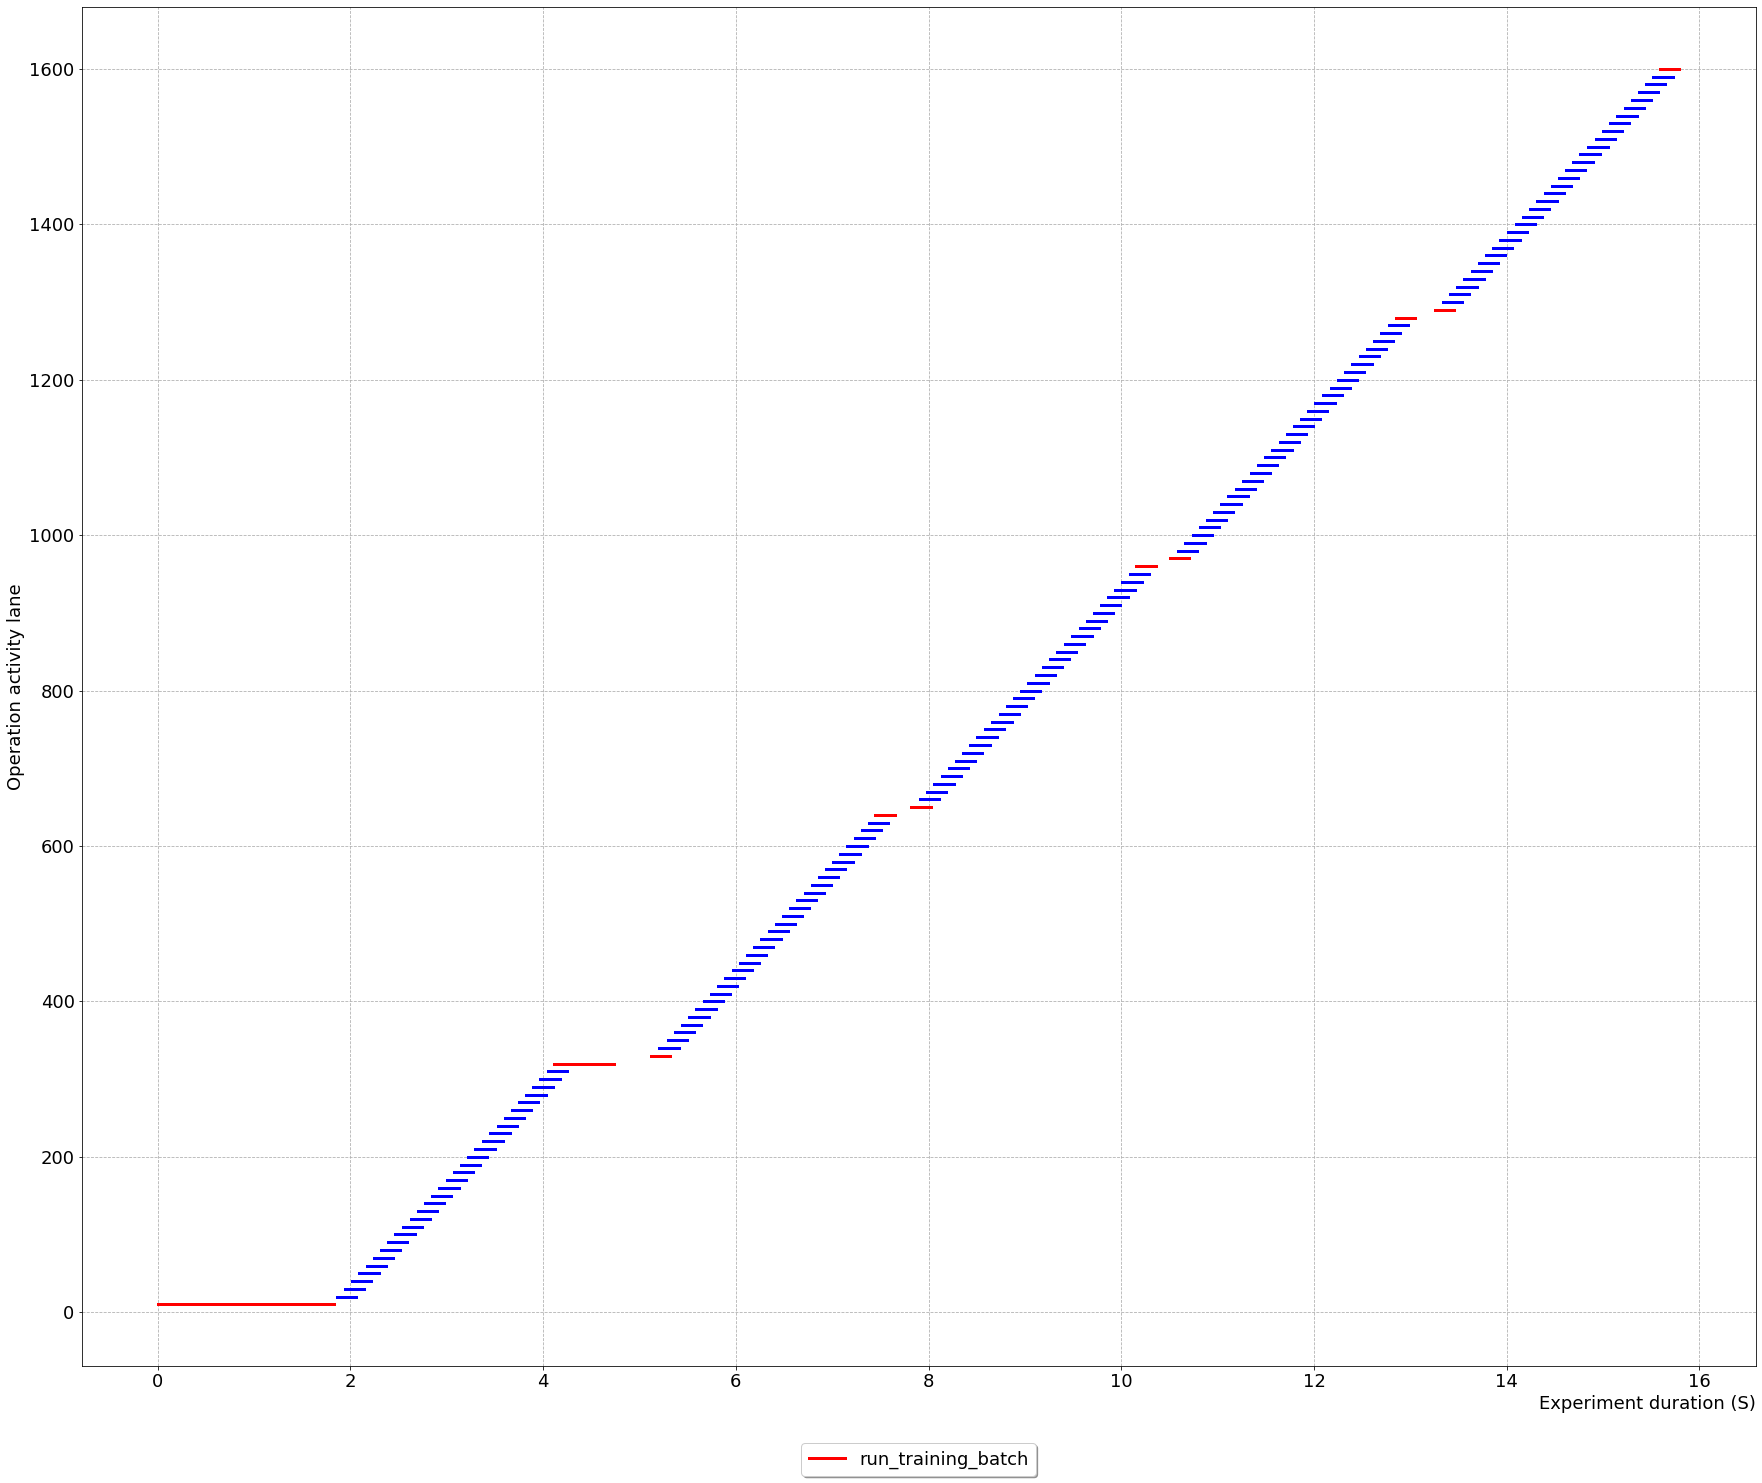

In [115]:
returns_scratch = []
function = "run_training_batch"

for run in sorted(unique_runs_scratch):
    print(run)
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run) & (df_dataloader_scratch["item_x"]==function)]
#     df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    dfgpu = df_gpuutil_scratch_corr[df_gpuutil_scratch_corr["run"]==run]
    returns_scratch.append(show_timelines_with_gpu3(df, dfgpu, lanes, colors, run, batches_per_epoch, False, True, False, 2))
    break

In [124]:
epochs_len = [e2-e1 for e1, e2 in zip(returns_scratch[0]["epoch_starts"], returns_scratch[0]["epoch_ends"])]
print(epoch_len)

[4.738102674484253, 2.532020998001099, 2.5340222835540764, 2.544767808914184, 2.5419353961944573]
